In [1]:
%pylab inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

Populating the interactive namespace from numpy and matplotlib


C:\Users\Mayur Maheshwari\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Importing train & test data

In [2]:
train = pd.read_csv('trainMerged.csv')
train.IsHoliday = train.IsHoliday.astype(int)
train['Type'] = LabelEncoder().fit_transform(train['Type'])

In [3]:
test = pd.read_csv('testMerged.csv')
test.IsHoliday = test.IsHoliday.astype(int)
test['Type'] = LabelEncoder().fit_transform(test['Type'])

In [4]:
train.describe()

,Store,IsHoliday,Dept,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000
mean,22.200546,0.070358,44.260317,15981.258123,0.589912,136727.915739,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289
std,12.785297,0.255750,30.492054,22711.183519,0.666337,60980.583328,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296
min,1.000000,0.000000,1.000000,-4988.940000,0.000000,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000
25%,11.000000,0.000000,18.000000,2079.650000,0.000000,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000
50%,22.000000,0.000000,37.000000,7612.030000,0.000000,140167.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000
75%,33.000000,0.000000,74.000000,20205.852500,1.000000,202505.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000
max,45.000000,1.000000,99.000000,693099.360000,2.000000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000


In [5]:
test.describe()

,Store,IsHoliday,Dept,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,114915.000000,86437.000000,105235.000000,102176.000000,115064.000000,76902.000000,76902.000000
mean,22.238207,0.077592,44.339524,0.592731,136497.688921,53.941804,3.581546,7689.216439,3734.051729,2403.088666,3356.219071,3922.681189,176.961347,6.868733
std,12.809930,0.267529,30.656410,0.668876,61106.926438,18.724153,0.239442,10698.760716,8323.495014,13767.939313,7570.501545,19445.150745,41.239967,1.583427
min,1.000000,0.000000,1.000000,0.000000,34875.000000,-7.290000,2.872000,-2781.450000,-35.740000,-179.260000,0.220000,-185.170000,131.236226,3.684000
25%,11.000000,0.000000,18.000000,0.000000,93638.000000,39.820000,3.431000,1966.460000,180.350000,15.100000,155.460000,1309.300000,138.402033,5.771000
50%,22.000000,0.000000,37.000000,0.000000,140167.000000,54.470000,3.606000,4842.290000,742.590000,78.260000,840.940000,2390.430000,192.304445,6.806000
75%,33.000000,0.000000,74.000000,1.000000,202505.000000,67.350000,3.766000,9439.140000,2735.670000,272.580000,3096.920000,4227.270000,223.244532,8.036000
max,45.000000,1.000000,99.000000,2.000000,219622.000000,101.950000,4.125000,103184.980000,71074.170000,149483.310000,65344.640000,771448.100000,228.976456,10.199000


# Imputing the missing values with regression technique for MarkDown's

In [6]:
t1 = train.dropna()
t1.drop(['Weekly_Sales'], axis=1, inplace=True)

C:\Users\Mayur Maheshwari\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [7]:
combine = pd.concat([t1, test], axis=0)
combine.dropna(inplace=True)

In [8]:
X = combine.drop(['Date', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment'], axis=1)
Y1 = combine.MarkDown1
Y2 = combine.MarkDown2
Y3 = combine.MarkDown3
Y4 = combine.MarkDown4
Y5 = combine.MarkDown5
lm1 = LinearRegression().fit(X,Y1)
lm2 = LinearRegression().fit(X,Y2)
lm3 = LinearRegression().fit(X,Y3)
lm4 = LinearRegression().fit(X,Y4)
lm5 = LinearRegression().fit(X,Y5)

In [9]:
train.MarkDown1 = np.where(train.MarkDown1.isnull() == 1, lm1.predict(train[X.columns]), train.MarkDown1)
train.MarkDown2 = np.where(train.MarkDown2.isnull() == 1, lm2.predict(train[X.columns]), train.MarkDown2)
train.MarkDown3 = np.where(train.MarkDown3.isnull() == 1, lm3.predict(train[X.columns]), train.MarkDown3)
train.MarkDown4 = np.where(train.MarkDown4.isnull() == 1, lm4.predict(train[X.columns]), train.MarkDown4)
train.MarkDown5 = np.where(train.MarkDown5.isnull() == 1, lm5.predict(train[X.columns]), train.MarkDown5)

In [10]:
test.MarkDown1 = np.where(test.MarkDown1.isnull() == 1, lm1.predict(test[X.columns]), test.MarkDown1)
test.MarkDown2 = np.where(test.MarkDown2.isnull() == 1, lm2.predict(test[X.columns]), test.MarkDown2)
test.MarkDown3 = np.where(test.MarkDown3.isnull() == 1, lm3.predict(test[X.columns]), test.MarkDown3)
test.MarkDown4 = np.where(test.MarkDown4.isnull() == 1, lm4.predict(test[X.columns]), test.MarkDown4)
test.MarkDown5 = np.where(test.MarkDown5.isnull() == 1, lm5.predict(test[X.columns]), test.MarkDown5)

In [11]:
train.shape

(421570, 16)

In [12]:
train.head()

,Store,Date,IsHoliday,Dept,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,10,2010-02-05,0,1,40212.84,1,126512,54.34,2.962,5840.702502,7802.533441,205.514784,3540.290087,4946.010778,126.442065,9.765
1,10,2010-02-05,0,98,74.00,1,126512,54.34,2.962,5842.381997,7767.112350,244.917351,3570.015842,4963.893868,126.442065,9.765
2,10,2010-02-05,0,32,26116.73,1,126512,54.34,2.962,5841.239248,7791.213299,218.107357,3549.790071,4951.725992,126.442065,9.765
3,10,2010-02-05,0,25,20779.50,1,126512,54.34,2.962,5841.118047,7793.769460,215.263872,3547.644913,4950.435460,126.442065,9.765
4,10,2010-02-05,0,34,50585.42,1,126512,54.34,2.962,5841.273876,7790.482967,218.919781,3550.402973,4952.094716,126.442065,9.765


In [13]:
train.dtypes

Store             int64
Date             object
IsHoliday         int32
Dept              int64
Weekly_Sales    float64
Type              int64
Size              int64
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
dtype: object

# Removing outliers

In [14]:
train.Weekly_Sales = np.where(train.Weekly_Sales>100000, 100000, train.Weekly_Sales)

# Splitting the train data further into Train and Test

In [15]:
X1 = train.drop(['Date', 'CPI', 'Unemployment', 'Weekly_Sales', 'MarkDown3'], axis=1)
Y = train.Weekly_Sales
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X1, Y, train_size=0.70, random_state=125)
sc = StandardScaler().fit(Xtrain)
sc_train = sc.transform(Xtrain)
sc_test = sc.transform(Xtest)

# Building models & comparing their RMSE values

In [16]:
lm = LinearRegression().fit(sc_train,Ytrain)

In [17]:
print (np.sqrt(mean_squared_error(lm.predict(sc_train),Ytrain)))
print (np.sqrt(mean_squared_error(lm.predict(sc_test),Ytest)))

19558.038523966552
19559.592783880616


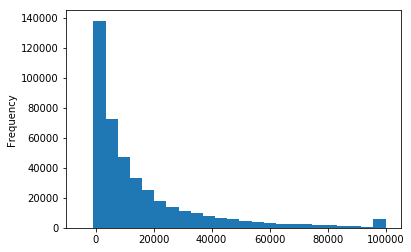

In [18]:
Y.plot.hist(bins=25)

In [19]:
dt = DecisionTreeRegressor(max_depth=14).fit(sc_train,Ytrain)

In [20]:
print (np.sqrt(mean_squared_error(dt.predict(sc_train),Ytrain)))
print (np.sqrt(mean_squared_error(dt.predict(sc_test),Ytest)))

4831.5453844658605
5520.192519302903


In [21]:
ad = AdaBoostRegressor().fit(sc_train,Ytrain)

In [22]:
print (np.sqrt(mean_squared_error(ad.predict(sc_train),Ytrain)))
print (np.sqrt(mean_squared_error(ad.predict(sc_test),Ytest)))

19433.837229150096
19436.625769987248


In [23]:
gbm = GradientBoostingRegressor().fit(sc_train,Ytrain)

In [24]:
print (np.sqrt(mean_squared_error(gbm.predict(sc_train),Ytrain)))
print (np.sqrt(mean_squared_error(gbm.predict(sc_test),Ytest)))

9857.195215101972
9827.904973372648


In [25]:
rf = RandomForestRegressor(n_estimators=10, max_depth=15, min_samples_split=10).fit(sc_train,Ytrain)

In [26]:
print (np.sqrt(mean_squared_error(rf.predict(sc_train),Ytrain)))
print (np.sqrt(mean_squared_error(rf.predict(sc_test),Ytest)))

4248.815054171398
4897.698392374795


# Predicting Sales value for test data

In [27]:
test1 = sc.transform(test[X1.columns])

In [28]:
p = pd.concat([test.Store.astype(str).str.cat(test.Dept.astype(str), sep='_').str.cat(test.Date.astype(str), sep='_'),
           pd.DataFrame(rf.predict(test1))], axis=1)

In [29]:
p.columns = ['Store_Dept_Date', 'Weekly_Sales']

In [31]:
p.to_csv('Submission_Walmart_Sales_Forecast.csv', index=0)